<h1 style='color:black'> Classes, Object-Orientation and Iterators</h1>

This exposition is adapted from Bloomberg ENG Training 'Python Object-Oriented Programming'.



The following block demonstrates <font color='red'> __deeper mechanism of classes__</font>, including <font color='red'> __class variables__ </font> (which can be used as RefCount), and introduces <font color='red'> __magic method__</font>. For a detailed exposition of magic methods, read Rafe Kettler's Magic Method Github page (there is a 19-page pdf) and also the python 3 document: https://docs.python.org/3/reference/datamodel.html#object.  

The following block also touches upon several <font color='red'>__decorators: @staticmethod, @property and @balance.setter__ </font>.

The following block also talks about how to put restrictions on the list of attributes, via `__slots__`.

**5 Intrinsic Class Attributes**
<ul>
    <li> `__name__`: name of the class (read only)
    <li> `__doc__`: class documentation string
    <li> `__module__`: module in which the class is defined
    <li> `__dict__`: map of all class attributes
    <li> `__base__`: tuple of all base class (but what if we have multiple inheritence?)
</ul>

**2 Intrinsic Object Attributes**
<ul>
    <li> `__class__`: the object's class
    <li> `__dict__`: map of all the object's attributes
</ul>

Python is an OO language, which supports the usual inheritence and polymorphism. For method overloading via inheritence, see the article **Super considered Super (you have not read it yet)**

**(What is duck typing?)**


In [1]:
class Account(object): # You should always inherit from object for base classes
    num_acs = 0 # Class variable - available as Account.num_acs
    __slots__ = ( 'name', 'trans' )
    
    # If we do not do the overloading of __init__ as below, __init__ of the base class (object in this case) will be called.
    # But generally, if we overload __init__ in the derived class, __init__ in the base class will not be called without super() - different from C++
    # For more details on the scope resolution of methods, see __mro__.
    def __init__(self, name): 
        self.name = name # Same as self.__dict__['name'] = name, i.e. . is a layer of abstraction. But __dict__ is not available for some classes
        self.trans = []
        Account.num_acs += 1 # Don't forget Account. or otherwise it is creating a local variable called num_acs. Recall LEGB - there is no class scope
        
    def get_all_trans(self): # If we ever need to implement a 'reference-getter' like this, some ideas below
        # return self.trans  # Just giving out the reference like this can be dangerous
        # return list(self.trans) # The copy constructor of a list is invoked and a deep copy is created - somehow safer
        return tuple(self.trans) # Tuple to make it not editable
    
    # There is some subtle difference between @staticmethod and @classmethod; see https://stackoverflow.com/questions/136097/what-is-the-difference-between-staticmethod-and-classmethod-in-python
    @staticmethod # Decoration
    def get_num_acs(): # No self in here
        return Account.num_acs
    # or get_num_acs = staticmethod(get_num_acs), if you do not want to do decoration as above.
    
    # The way that python does attribute access control, i.e. restrict one or multiple of reading, writing and deleting 
    # is to define decorated *methods* with the same name of the data member, as follows.
    # The following is also a way to define calculated attributes
    @property # only allows for reading - another way is to define a descriptor object (more on that below)
    def balance(self):
        return self._balance # _ indicates internal shadow variable. Of course, python does not dis-allow private access of variables.

    @balance.setter # only allows for writing
    def balance(self, value):
        self._balance = value
        # or if you want to have calculated attributes: return sum(self.trans)
    
    def __iadd__(self, amount): # What is the subtle difference in defining __add__ and __iadd__?
        self.trans.append(amount)
        return self # This is essential or otherwise the result of += would be a NoneType
    
    def __getitem__(self, index):
        return self.trans[index]
    
    def __gt__(self, other): # Overloading >. Example omitted below.
        return self.balance > other.balancere
    
    def __str__(self):
        return "This should return a human readable message that can help debugging."
    

# __init__ and __new__ together fulfills the job of a constructor. 
b1 = Account('joe')
# What actually happens
# rv = Account.__new__(...)  
# __new__ allocates the memory
# Account.__init__(rv, 'joe') 
# Again there will be exceptions if we do not overload __init__

# Sometimes a magic method can customize how built-in functions behave, because built-in function is just calling this magic methods.
# str is one such example. 
# You can also try overlaoding, e.g. float()
str(b1) 

# Scoping of methods    
b1.get_all_trans()
# What actually happens
# b1.__class__.get balance(b1) 
# __class__ determines the scope of the level of the class (i.e. the base class or the derived class) being called

# __iadd__ overlaoding
b1 += 100 
b1 += (-10)

# __getitem overloading
assert b1[0] == 100
# What actually happens
# b1.__class__.__getitem__(b1,0)

# But it gets even better...
assert b1[0:2] == [100,-10] # __getitem__ getes an object as its second variable. 
                           #In the old days (<2.6), there used to be a method called __getslice__ which calls __getitem__ multiple times

# This also works because (the default) __iter__ method calls __getitem__, and for loop calls the __iter__ 
# So we get __iter__ for free (though sometimes not exactly what you desire) once we have __getitem__ working.    
for trans in b1:
    print(trans) 

# List can take an iterable (any object with __iter__) into a list. So this works as well.
print(list(b1)) 

# Without __slots__, the following will go through, creating a new attribute ballance in Account.
# More braodly, object attributes can be defined on the fly. 
# For example, this instance b1 of Account will have attribute ballance, while ballance is not an attributed organically in Account
#b1.ballance = 100000


100
-10
[100, -10]


The following block introduces <font color='red'> __abstract base class__ </font> and also how to <font color='red'> __chain methods across inheritance classes__ </font>, i.e. the use of <font color='red'> __super__ </font>. For a deeper exposition of super(), see https://rhettinger.wordpress.com/2011/05/26/super-considered-super

In [2]:
from abc import abstractmethod, ABCMeta

class Shape(object):
    __metaclass__ = ABCMeta # Magic variable to register meta class, in this case it is abstract base class
    
    @abstractmethod
    def display(self):
        print("base display") # You can still have implementation in an abstract method
        
class Square(Shape):
    def display(self): # Without defining this, an instance cannot be initialized for Square
        Shape.display(self) # one way to call the same method in a base class
        # super(Square, self).display() - in python 3, the parameters in the parantheses are omitted.
        print('displaying')
        
# This will throw
# sh = Shape()

sq = Square()
sq.display()
        

base display
displaying


The following block touches upon <font color='red'> __meta classes__ </font>. Metaclasses can be useful when you are trying to override static or class methods for a bunch of classes - you can specify the bunch of classes to have the same meta class. Applications of meta classes include (1) standardizing class construction (customizing `__new__`) and (2) logging class construction. Fun fact: `type` can be used to initialize a class beside checking the type of an object, and `type` is central in the concept of meta-classes. But average python user does not need to worry about meta-classes. See a primer on meta classes: https://jakevdp.github.io/blog/2012/12/01/a-primer-on-python-metaclasses

In [3]:
# type is a meta class, which can be used to factory classes, as in type(<class name>, <parameters>, <attributes>)

class Checker(type):
    def __new__(cls, name, bases, atts):
        # cls: the meta class itself - it is called cls by convention.
        # name: name of the class
        # bases: the base classes
        # atts: the attributes
        if '__init__' not in atts:
            raise Exception('must have __init__')
        return type.__new__(cls, name, bases, atts)
    
class C(object):
    __metaclass__ = Checker
    def __init__(self):
        pass

The following block talks about <font color='red'> **descriptor** </font> and extend further on <font color='red'> **attribute access control** </font>. Look at the following graph for reference.

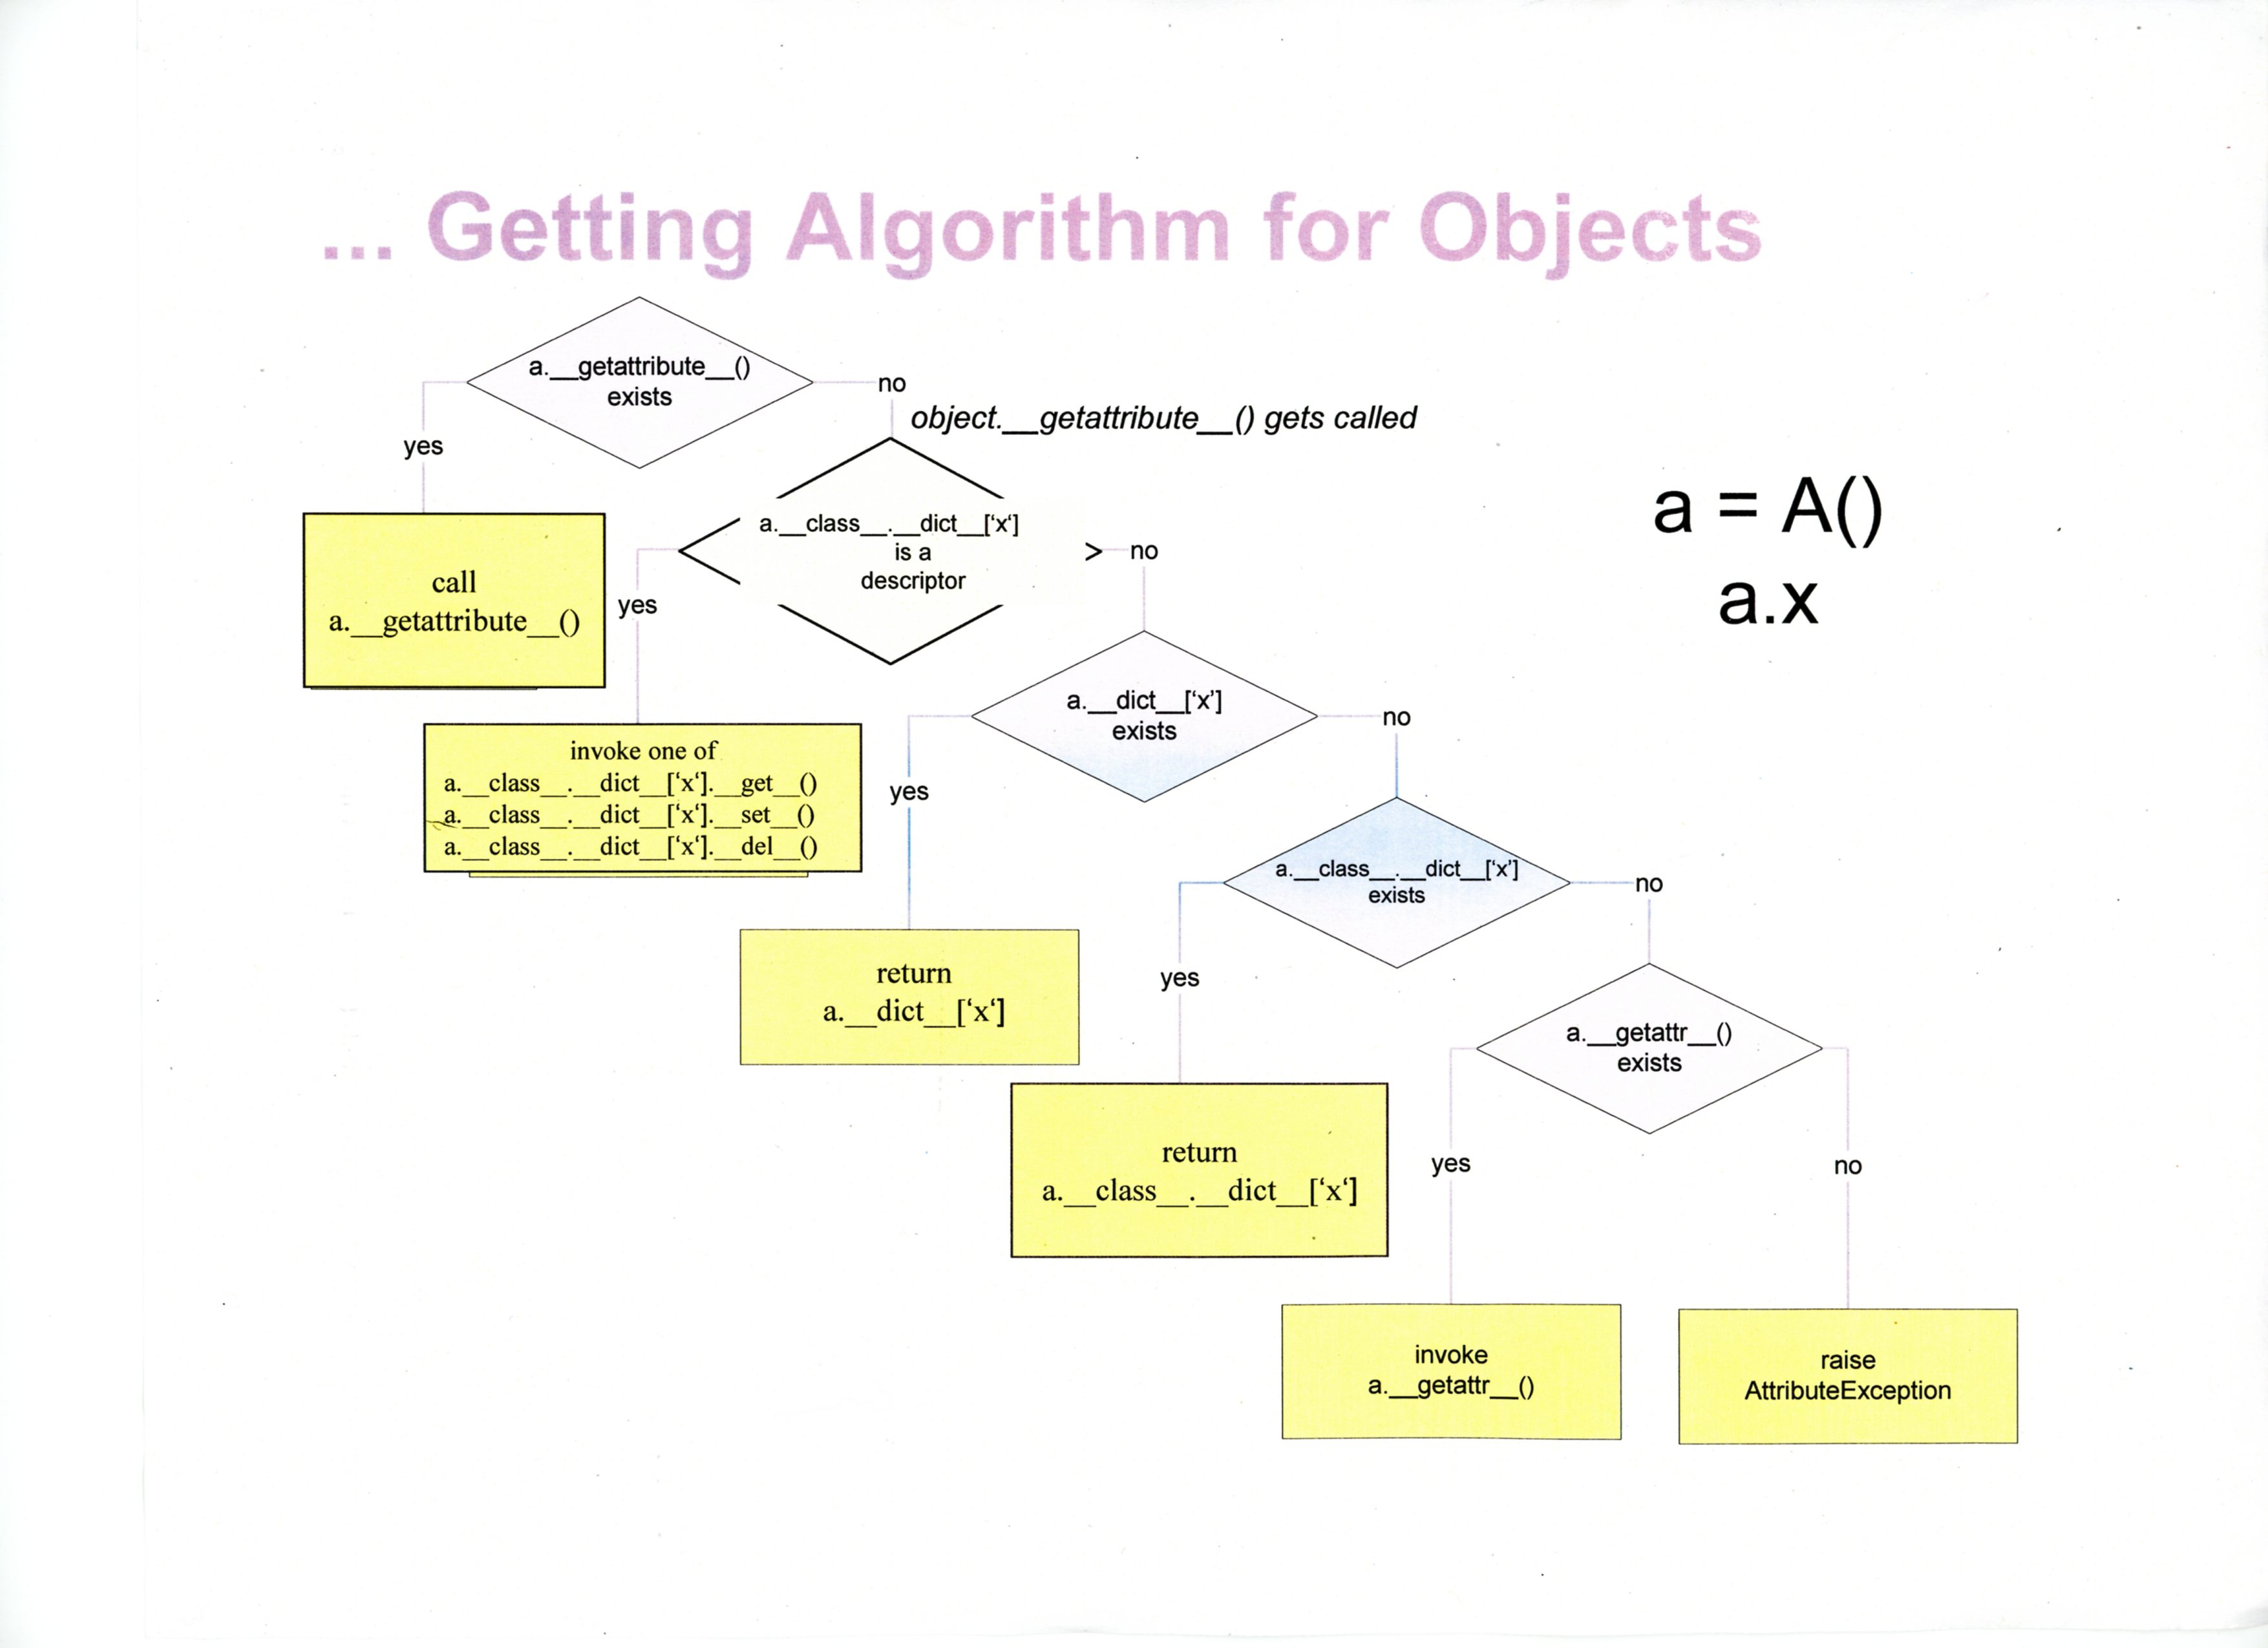

In [5]:
from IPython.display import Image
import os.path
path = r"C:\Users\Yixian\Documents\Python Learning Notes"
file = "Attributes Access.jpg"
Image(filename = os.path.join(path, file))

In [ ]:
# How a class variable can control get, set and del access for instance variables

class Trace(object): # This is a descriptor object, which defines __get__, __set__ and __del__ (see Powerpoint)
    def __init__(self, attname):
        self.attname = attname
        
    def __get__(self, obj, obj_type): # Required signature: obj represents the specific instance of the class
        return obj.__dict__[self.attname]
    
    def __set__(self, obj, val):
        print 'setter' + str(self.attname) + str(val)
        obj.__dict__[self.attname] = val
        
    def __del__(self, obj):
        print 'cannot delete'
        
class A(object):
    '''
    # Top of the flow chart. But defined in this way, a.att for ANY att is gonna return 100. 
    # So this is not really useful in most cases...
    def __getattribute__(self, attname):
        print attname
        return 100
        
    # Useful for caching: if something being accessed needs calculation, it may worth being populated in __dict__
    '''
    # With user-defined Trace(), this class variable x controls access for instance variable x, 
    # making use of the second step in the flow chart.
    x = Trace()
    def __init__(self):
        self.x = 42
        
a = A()

# a.x = 42 # Add variable is just adding to the internal dictionary.

print a.x
a.x = 100
print a.x
del a.x
print a.x